# Readme
- 넥라인 데이터에 대한 transfer-learning

# 넥라인 데이터

In [2]:
from tqdm import tqdm
import numpy as np

import os
import glob
import zipfile

#from PIL import Image # PIL은 조금 무거운것 같다
import cv2 # (주의)imshow 할때는 google에서 제공하는 lib 써야한다(아래 Lib)
from google.colab.patches import cv2_imshow

import matplotlib.pyplot as plt

import pandas as pd

from tqdm.notebook import tqdm, tqdm_notebook



---



---



# 1. Input Data 준비
- 데이터 프레이 활용
> - img_path /  status(label)

In [5]:
glob.glob('crop_neckline_filtering/*')[:5]

['crop_neckline_filtering/class_1_265.jpg',
 'crop_neckline_filtering/class_1_260.jpg',
 'crop_neckline_filtering/class_1_202.jpg',
 'crop_neckline_filtering/class_1_197.jpg',
 'crop_neckline_filtering/class_1_223.jpg']

In [7]:
### for train - get  path / status ###

total_path = []
total_status = []

### class 17 에 대해서 - path/bbox 얻는 작업 ###
for img_path in tqdm_notebook( glob.glob('crop_neckline_filtering/*') ):
  total_path.append(img_path)
  total_status.append( img_path.split('_')[3] )

In [8]:
print(len(total_path))
print(len(total_status))

617
617


In [9]:
## dataframe 만들기

df = pd.DataFrame({'filename':total_path,  'status':total_status})

df.head()

,filename,status
0,crop_neckline_filtering/class_1_265.jpg,1
1,crop_neckline_filtering/class_1_260.jpg,1
2,crop_neckline_filtering/class_1_202.jpg,1
3,crop_neckline_filtering/class_1_197.jpg,1
4,crop_neckline_filtering/class_1_223.jpg,1


In [11]:
df['status'] = df['status'].astype(int)

## cf. 불러와서 이용할때

In [ ]:
### 저장해서 이용하자 - tuple이 str로 변환되는 문제 : https://www.reddit.com/r/learnpython/comments/44dpgd/convert_pandas_dataframe_column_from_str_to_tuple/
#import ast

#df.to_csv('necklinebbox_status_0619.csv', index=False)
#df = pd.read_csv('necklinebbox_status_0619.csv',   converters={"bbox": ast.literal_eval} ) # 

In [12]:
len(df)

617

In [13]:
df.groupby('status').size()

status
0    187
1    219
2    211
dtype: int64

In [14]:
# split dataframe / train(0.8), test(0.2)
total_data_count = len(df)
train_index = np.random.choice(len(df), int(0.8*len(df)), replace=False )


df_train = df[ df.index.isin(train_index)].reset_index(drop=True)
df_valid = df[~df.index.isin(train_index)].reset_index(drop=True)

In [15]:
print(len(df_train), len(df_valid) )

493 124


## # 훈련셋만 균형지게 만들기

In [16]:
# equal-sized 데이터 만들기

def make_equal_size(df, class_name=None):
  if not class_name:
    class_name = 'status'
  top_class = df[class_name].value_counts().index[0]
  size = df[df[class_name] == top_class].shape[0]

  df_equal_size = pd.DataFrame()
  for class_key, grp in df.groupby(class_name):
    if class_key == top_class:
      df_equal_size = pd.concat([df_equal_size, grp], axis=0)
    else:
      equal_sampled = grp.sample(n = size, replace=True)
      df_equal_size = pd.concat([df_equal_size, equal_sampled], axis=0)
  
  df_equal_size = df_equal_size.reset_index(drop=True)
  return df_equal_size

In [17]:
# 불균형 데이터 맞춰준다
df_train = make_equal_size(df = df_train)

In [18]:
df_train.groupby('status').size()

status
0    176
1    176
2    176
dtype: int64

---
---

# 2. 훈련

## # using generator

In [19]:
##### generator #####

from tensorflow.keras.utils import Sequence

#------------------------------------------------------
# CropDataset
class CropDataset(Sequence):
    #---------------------------------------------
    # constructor
    def __init__(self, df, batch_size=16, target_size=(192,192), mode='train', shuffle=True, aug=False):

        self.len_df = len(df)
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle

        if mode == 'train' and aug == True:
            self.aug = True
        else:
            self.aug = False

        self.file_list = df['filename'].tolist()
        #self.bbox_list = df['bbox'].tolist()  ############################ 지금은 crop이미지를 불러오니깐 해당 line 주석처리 (밑에도 같은 이유) ##########################################

        self.label_list = df['status'].tolist()

        self.on_epoch_end()

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.file_list))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.floor(self.len_df) / self.batch_size)

    def __data_generation(self, indexes):

        X = np.empty((self.batch_size, *self.target_size, 3))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, idx in enumerate(indexes):

            file_name = self.file_list[idx]
            # img_path 경로를 추가.
            img_path = file_name

            img = self._read_img(img_path)
            #bbox = self.bbox_list[idx]   ######################################################################
            label = self.label_list[idx]

            #crop_img = self._get_crop_img(img, bbox)   ######################################################################

            #resized_crop_img = self._resize_img(crop_img)   ######################################################################

            # normalization
            normalized_img = img / 255.   ######################################################################

            # data augmentation
            if self.aug:
                normalized_img = self._get_augmentated_img(normalized_img)   ######################################################################

            X[i, ] = normalized_img
            y[i, ] = label

        return X, y

    def __getitem__(self, index):
        # Generate one batch of data
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(indexes)

        return X, y

    def _get_crop_img(self, img, bbox):
        # img : numpy_array
        # bbox : list [1,1,1,1]
        background = np.zeros_like(img)

        size = img.shape[0]

        y_min, x_min, y_max, x_max = bbox
        # 30%의 상위 이미지만 네크라인 이미지로 활용
        alpha = (y_max-y_min)*0.5
        y_max = np.int(y_min + alpha)


        roi = img[y_min:y_max, x_min:x_max]

        roi_height = roi.shape[0]
        roi_width = roi.shape[1]

        #roi = Image.fromarray(np.uint8(roi))

        roi_size = max(roi_height, roi_width)


        if roi_height == roi_size:
            check = 'height'
            re_height = size
            re_width = int(size * roi_width / roi_height)
        else:
            check = 'width'
            re_height = int(size * roi_height / roi_width)
            re_width = size

        resize_roi = cv2.resize(roi, dsize=(re_width,re_height)  ,interpolation=cv2.INTER_AREA) # 여기 바꿨다 - roi = Image.fromarray(np.uint8(roi)) 바뀌면서 수정한거야
        np_roi = np.array(resize_roi , dtype=np.uint8) # 형도 지정해주었다

        re_roi_height = np_roi.shape[0]
        re_roi_width = np_roi.shape[1]

        roi_y_coord = int(re_roi_height/2)
        roi_x_coord = int(re_roi_width/2)

        center = int(size / 2)

        if check == 'height':
            background[:, (center-roi_x_coord):(center-roi_x_coord+re_roi_width)] = np_roi
        else:
            background[(center-roi_y_coord):(center-roi_y_coord+re_roi_height), :] = np_roi
        
        background = background.astype(np.uint8) # 한번 더 형 지정

        return background

    def _read_img(self, img_path):
        
        img = cv2.imread(img_path) # array 형태
        cv2_resize_img = cv2.resize(img, dsize=(192,192)  ,interpolation=cv2.INTER_AREA)
        
        return cv2_resize_img

    def _resize_img(self, img):
  
        # img resize
        resize_img = cv2.resize(img, dsize=(192,192)  ,interpolation=cv2.INTER_AREA)

        np_img = np.array(resize_img)

        return np_img




    def _get_augmentated_img(self, img,
                              rotation_range= 20,
                              width_shift_range= 0.05,
                              height_shift_range= 0.05,
                              shear_intensity = False,
                              zoom_range= (1.0, 1.5), #(0.9, 1.1),
                              horizontal_flip=True,
                              vertical_flip=False
                              ):


        if rotation_range:
            img = tf.keras.preprocessing.image.random_rotation(img, rg = rotation_range, row_axis=0, col_axis=1, channel_axis=2, fill_mode = 'constant', cval=0.0)

        if width_shift_range:
            img = tf.keras.preprocessing.image.random_shift(img, wrg = width_shift_range, hrg = 0, row_axis=0, col_axis=1, channel_axis=2, fill_mode = 'constant', cval=0.0)

        if height_shift_range:
            img = tf.keras.preprocessing.image.random_shift(img, wrg = 0, hrg = height_shift_range, row_axis=0, col_axis=1, channel_axis=2, fill_mode = 'constant', cval=0.0)


        if shear_intensity:
            img = tf.keras.preprocessing.image.random_shear(img, intensity=shear_intensity, row_axis=0, col_axis=1, channel_axis=2, fill_mode = 'constant', cval=0.0)

        if zoom_range:
            img = tf.keras.preprocessing.image.random_zoom(img, zoom_range=zoom_range, row_axis=0, col_axis=1, channel_axis=2, fill_mode = 'constant', cval=0.0)

        if vertical_flip:
          vertical_flip_bool = np.random.choice( [True, False] )
          if vertical_flip_bool == True:
            img = tf.image.flip_up_down( img )

        #
        if horizontal_flip:
          horizontal_flip_bool = np.random.choice([True, False])
          if horizontal_flip_bool == True:
            img = tf.image.flip_left_right(img)

        return img


- 이미지 확인

In [20]:
# parameter for training
BATCH_SIZE = 16
IMG_WIDTH = 192
AUG = True

# make train generator
train_data_generator = CropDataset(df = df_train,
                                    batch_size=BATCH_SIZE,
                                    target_size=(IMG_WIDTH, IMG_WIDTH),
                                    mode='train',
                                    shuffle=True,
                                    aug=AUG)

# make val generator
val_data_generator = CropDataset(df = df_valid,
                                  batch_size = len(df_valid),
                                  #batch_size = BATCH_SIZE,
                                  target_size=(IMG_WIDTH, IMG_WIDTH),
                                  mode='val',
                                  shuffle=False,
                                  aug=False)

In [ ]:
#test_data_generator = CropDataset(df = df_test_sample,
#                                  batch_size = len(df_test_sample),
#                                  target_size = (IMG_WIDTH, IMG_WIDTH),
#                                  mode = 'test',
#                                  shuffle=False,
#                                  aug=False                                  
#                                  )

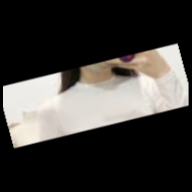

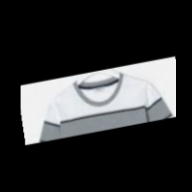

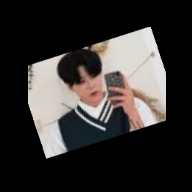

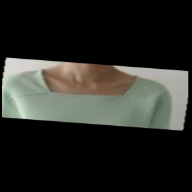

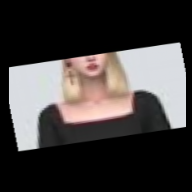

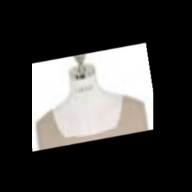

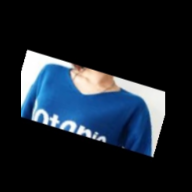

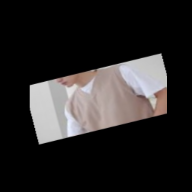

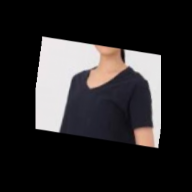

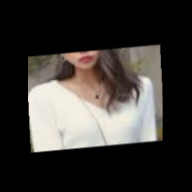

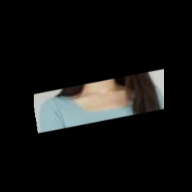

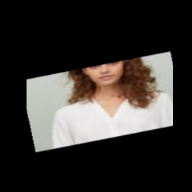

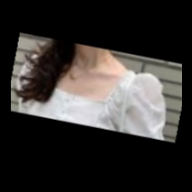

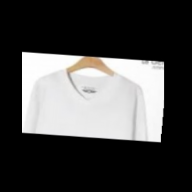

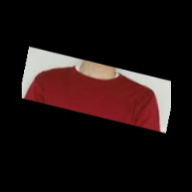

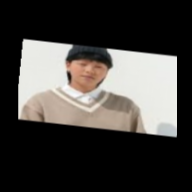

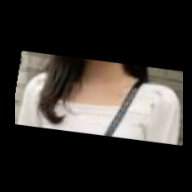

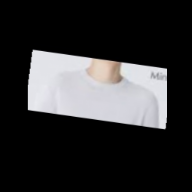

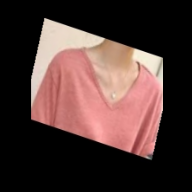

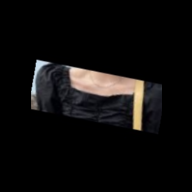

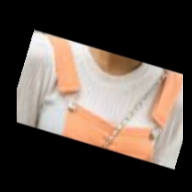

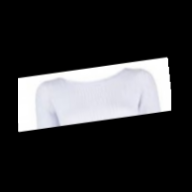

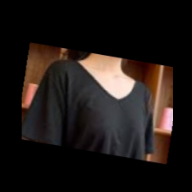

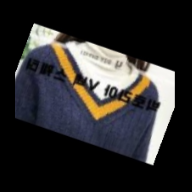

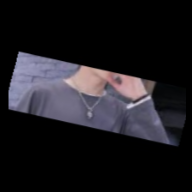

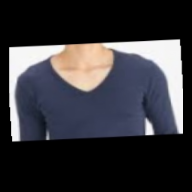

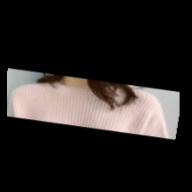

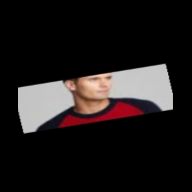

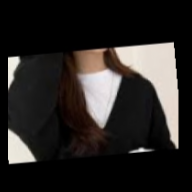

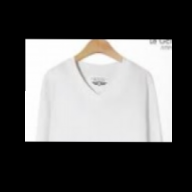

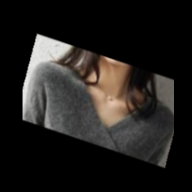

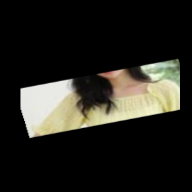

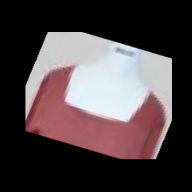

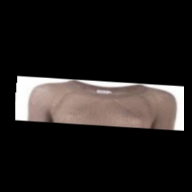

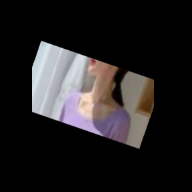

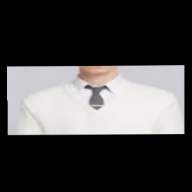

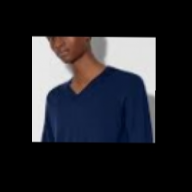

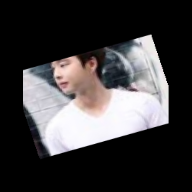

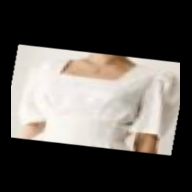

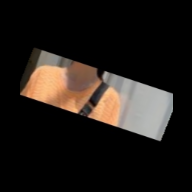

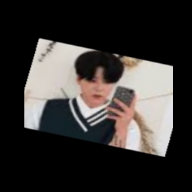

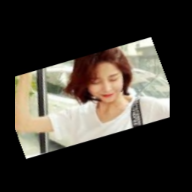

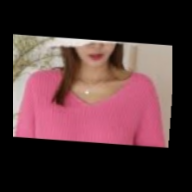

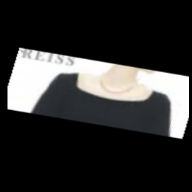

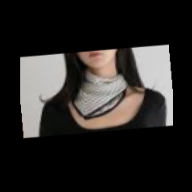

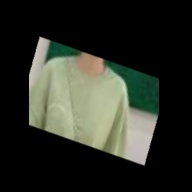

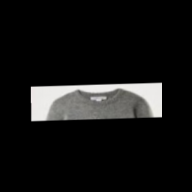

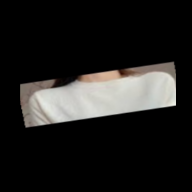

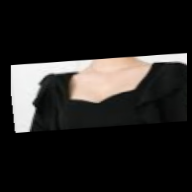

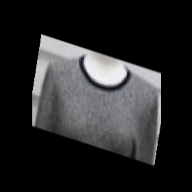

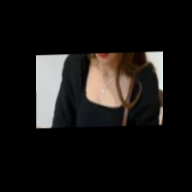

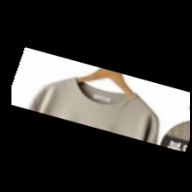

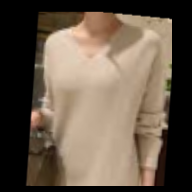

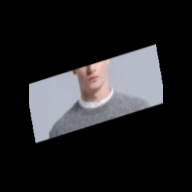

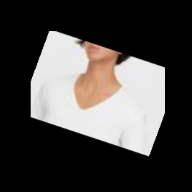

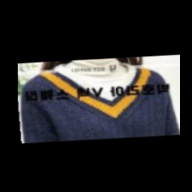

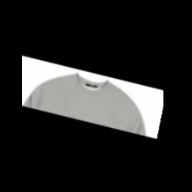

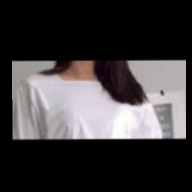

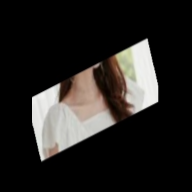

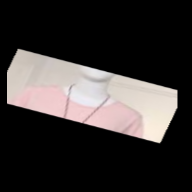

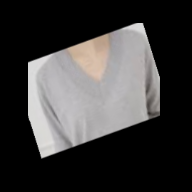

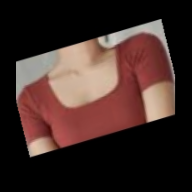

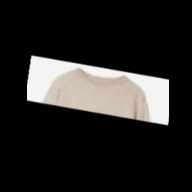

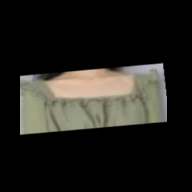

In [ ]:
import tensorflow as tf

from google.colab.patches import cv2_imshow

for img in train_data_generator[0][0]:
  cv2_imshow( img*255 )
  print('')

## # Training 실행

In [43]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam,RMSprop, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

n_class = 3

# feature extractor
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(192, 192, 3))

# freeze or training base model
base_model.trainable = True

transfer_model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        BatchNormalization(),
        Dense(512, activation='softmax'),
        BatchNormalization(),
        Dense(n_class, activation='softmax')
    ])

transfer_model.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

transfer_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1280)              0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 1280)              5120      
_________________________________________________________________
dense_10 (Dense)             (None, 512)               655872    
_________________________________________________________________
batch_normalization_11 (Batc (None, 512)               2048      
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 1539      
Total params: 2,922,563
Trainable params: 2,884,867
Non-trainable params: 37,696
_______________________________________

In [44]:
history = transfer_model.fit_generator(
    train_data_generator,
    epochs = 50,
    validation_data=val_data_generator,
    verbose=1)

Epoch 1/50
33/33 [==============================] - 20s 599ms/step - loss: 1.0861 - accuracy: 0.3864 - val_loss: 1.0989 - val_accuracy: 0.3226
Epoch 2/50
33/33 [==============================] - 19s 576ms/step - loss: 1.0216 - accuracy: 0.5360 - val_loss: 1.0988 - val_accuracy: 0.3306
Epoch 3/50
33/33 [==============================] - 19s 572ms/step - loss: 0.9423 - accuracy: 0.6591 - val_loss: 1.0991 - val_accuracy: 0.3226
Epoch 4/50
33/33 [==============================] - 19s 569ms/step - loss: 0.8721 - accuracy: 0.6780 - val_loss: 1.0967 - val_accuracy: 0.3629
Epoch 5/50
33/33 [==============================] - 19s 571ms/step - loss: 0.8030 - accuracy: 0.7443 - val_loss: 1.0944 - val_accuracy: 0.3629
Epoch 6/50
33/33 [==============================] - 19s 572ms/step - loss: 0.6922 - accuracy: 0.7765 - val_loss: 1.0906 - val_accuracy: 0.3952
Epoch 7/50
33/33 [==============================] - 19s 571ms/step - loss: 0.6042 - accuracy: 0.8087 - val_loss: 1.0871 - val_accuracy: 0.3871

In [29]:
preds = transfer_model.predict_generator(val_data_generator)
preds_cls_idx = preds.argmax( axis=-1 ) # max-idx 저장

In [31]:
preds_cls_idx

array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 2, 0, 1, 0, 2, 0, 0, 0, 0, 1, 0, 1, 0, 0, 2, 1, 0, 0, 1,
       0, 2, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1])

In [ ]:
(preds_cls_idx == df_valid['status']).mean()